In [9]:
import torch
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
# Generate the dataset
data, _ = datasets.make_moons(3000, noise=0.05)
data = data.astype("float32")

# Using StandardScaler from sklearn for normalization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Convert to PyTorch tensor
normalized_data = torch.tensor(normalized_data)



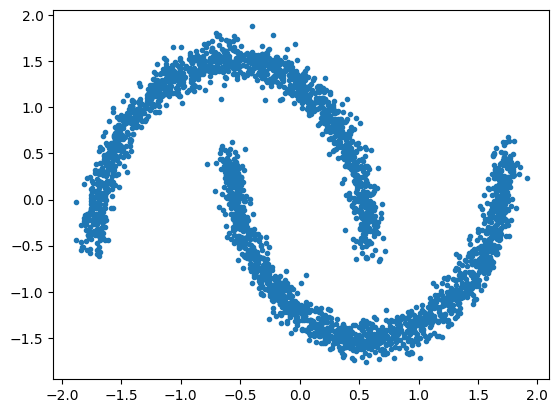

In [10]:
plt.plot(normalized_data[:, 0], normalized_data[:, 1], ".")

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Coupling(nn.Module):
    def __init__(self, input_dim, coupling_dim, regularization):
        super(Coupling, self).__init__()
        self.s_layer_1 = nn.Linear(input_dim, coupling_dim)
        self.s_layer_2 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_3 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_4 = nn.Linear(coupling_dim, coupling_dim)
        self.s_layer_5 = nn.Linear(coupling_dim, input_dim)
        
        self.t_layer_1 = nn.Linear(input_dim, coupling_dim)
        self.t_layer_2 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_3 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_4 = nn.Linear(coupling_dim, coupling_dim)
        self.t_layer_5 = nn.Linear(coupling_dim, input_dim)

        self.l2_reg = regularization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        s = torch.relu(self.s_layer_1(x))
        s = torch.relu(self.s_layer_2(s))
        s = torch.relu(self.s_layer_3(s))
        s = torch.relu(self.s_layer_4(s))
        s = torch.tanh(self.s_layer_5(s))
        
        t = torch.relu(self.t_layer_1(x))
        t = torch.relu(self.t_layer_2(t))
        t = torch.relu(self.t_layer_3(t))
        t = torch.relu(self.t_layer_4(t))
        t = self.t_layer_5(t)  # No activation function
        
        return s, t

In [29]:
input_dim = 2
coupling_layers = 6
coupling_dim = 256
regularization = 0.01

model = Coupling(input_dim, coupling_dim, regularization)
input_tensor = torch.randn(1, 2)  
s_output, t_output = model(input_tensor)
print("s_output:", s_output)
print("t_output:", t_output)


s_output: tensor([0.0161, 0.0054], grad_fn=<SelectBackward0>)
t_output: tensor([-0.0052, -0.0149], grad_fn=<SelectBackward0>)


In [68]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = torch.distributions.MultivariateNormal(
            torch.zeros(input_dim), torch.eye(input_dim)
        )
        self.masks = torch.tensor(
            [[0, 1],
             [1, 0]] * (coupling_layers // 2), dtype=torch.float32
        )
        self.layers_list = nn.ModuleList(
            [Coupling(input_dim, coupling_dim, regularization) for _ in range(coupling_layers)]
        )
        self.loss_tracker = []

    def forward(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s = s * reversed_mask
            t = t * reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask * (x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
                + x_masked
            )
            log_det_inv = log_det_inv + gate * torch.sum(s, dim=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -torch.mean(log_likelihood)

    def training_step(self, data, optimizer):
        self.train()
        optimizer.zero_grad()
        loss = self.log_loss(data)
        loss.backward()
        optimizer.step()
        self.loss_tracker.append(loss.item())
        return loss.item()

    def test_step(self, data):
        self.eval()
        with torch.no_grad():
            loss = self.log_loss(data)
            self.loss_tracker.append(loss.item())
        return loss.item()





In [75]:
input_dim = 2
coupling_layers = 6
coupling_dim = 256
regularization = 0.01
learning_rate = 0.0001
epochs = 300
batch_size = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RealNVP(input_dim, coupling_layers, coupling_dim, regularization)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=70, gamma=0.0001)

model.to(device)

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(normalized_data), batch_size):
        batch_data = normalized_data[i:i + batch_size]
        batch_data = torch.tensor(batch_data, dtype=torch.float32).to(device)
        loss = model.training_step(batch_data, optimizer)
        total_loss = total_loss + loss
    average_loss = total_loss / (len(normalized_data) // batch_size)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")
    # scheduler.step()

C:\Users\SIVERMA\AppData\Local\Temp\ipykernel_5316\1492935821.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = torch.tensor(batch_data, dtype=torch.float32).to(device)


Epoch 1/300, Loss: 2.9280
Epoch 2/300, Loss: 2.8398
Epoch 3/300, Loss: 2.7980
Epoch 4/300, Loss: 2.7609
Epoch 5/300, Loss: 2.7293
Epoch 6/300, Loss: 2.7065
Epoch 7/300, Loss: 2.6883
Epoch 8/300, Loss: 2.6718
Epoch 9/300, Loss: 2.6545
Epoch 10/300, Loss: 2.6362
Epoch 11/300, Loss: 2.6166
Epoch 12/300, Loss: 2.5965
Epoch 13/300, Loss: 2.5766
Epoch 14/300, Loss: 2.5570
Epoch 15/300, Loss: 2.5384
Epoch 16/300, Loss: 2.5207
Epoch 17/300, Loss: 2.5042
Epoch 18/300, Loss: 2.4893
Epoch 19/300, Loss: 2.4756
Epoch 20/300, Loss: 2.4628
Epoch 21/300, Loss: 2.4505
Epoch 22/300, Loss: 2.4377
Epoch 23/300, Loss: 2.4234
Epoch 24/300, Loss: 2.4052
Epoch 25/300, Loss: 2.3791
Epoch 26/300, Loss: 2.3462
Epoch 27/300, Loss: 2.3159
Epoch 28/300, Loss: 2.2945
Epoch 29/300, Loss: 2.2814
Epoch 30/300, Loss: 2.2701
Epoch 31/300, Loss: 2.2565
Epoch 32/300, Loss: 2.2384
Epoch 33/300, Loss: 2.2201
Epoch 34/300, Loss: 2.2031
Epoch 35/300, Loss: 2.1880
Epoch 36/300, Loss: 2.1733
Epoch 37/300, Loss: 2.1591
Epoch 38/3

C:\Users\SIVERMA\AppData\Local\Temp\ipykernel_5316\2084798746.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data)


Test Loss: 1.3995


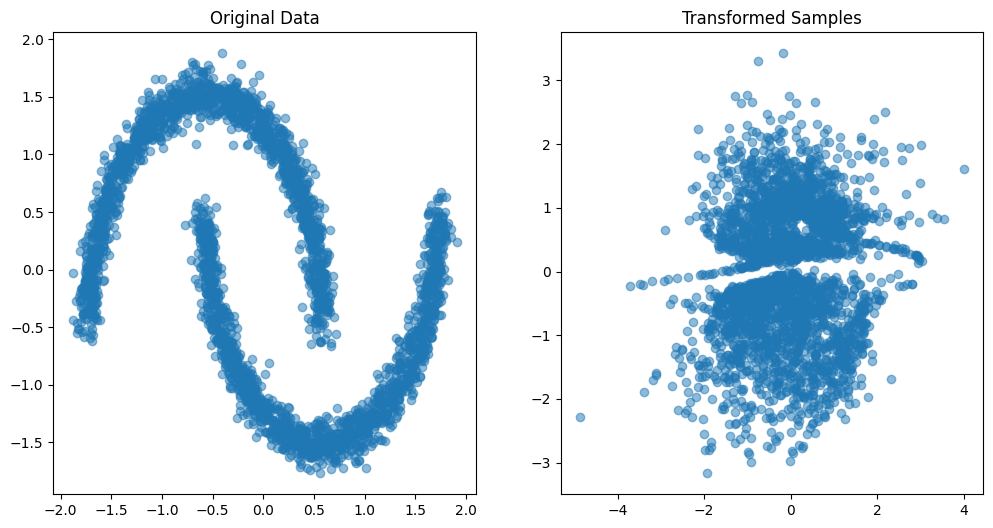

In [77]:

data = normalized_data

data_tensor = torch.tensor(data)
test_loss = model.test_step(data_tensor.to(device))
print(f"Test Loss: {test_loss:.4f}")

with torch.no_grad():
    samples, _ = model(data_tensor.to(device), training=True)
    samples = samples.cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)

plt.subplot(1, 2, 2)
plt.title("Transformed Samples")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)

plt.show()


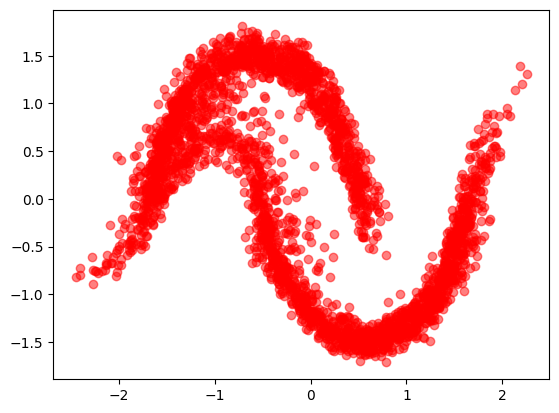

In [78]:
num_samples = 3000
base_samples = model.distribution.sample((num_samples,)).to(device)

# Apply the inverse transformation
with torch.no_grad():
    transformed_samples, _ = model(base_samples, training=False)
    transformed_samples = transformed_samples.cpu().numpy()


plt.scatter(transformed_samples[:, 0], transformed_samples[:, 1], alpha=0.5, color="red")

plt.show()